In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
import series as s
from download import query_phe as query, download_phe as download, find_latest
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from plotting import per1m_formatter, per1k_formatter, per0k_formatter
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [41]:
release=None

In [42]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-02-10,2021-02-09,United Kingdom,K02000001,NaN,NaN,132.0,579266.0
1,2021-02-10,2021-02-08,United Kingdom,K02000001,12410.0,NaN,468.0,616718.0
2,2021-02-10,2021-02-07,United Kingdom,K02000001,10913.0,NaN,486.0,584933.0
3,2021-02-10,2021-02-06,United Kingdom,K02000001,11598.0,1872.0,530.0,454008.0
4,2021-02-10,2021-02-05,United Kingdom,K02000001,15762.0,1989.0,611.0,671585.0
...,...,...,...,...,...,...,...,...
372,2021-02-10,2020-02-03,United Kingdom,K02000001,0.0,NaN,NaN,NaN
373,2021-02-10,2020-02-02,United Kingdom,K02000001,1.0,NaN,NaN,NaN
374,2021-02-10,2020-02-01,United Kingdom,K02000001,1.0,NaN,NaN,NaN
375,2021-02-10,2020-01-31,United Kingdom,K02000001,2.0,NaN,NaN,NaN


In [43]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-02-10.csv')

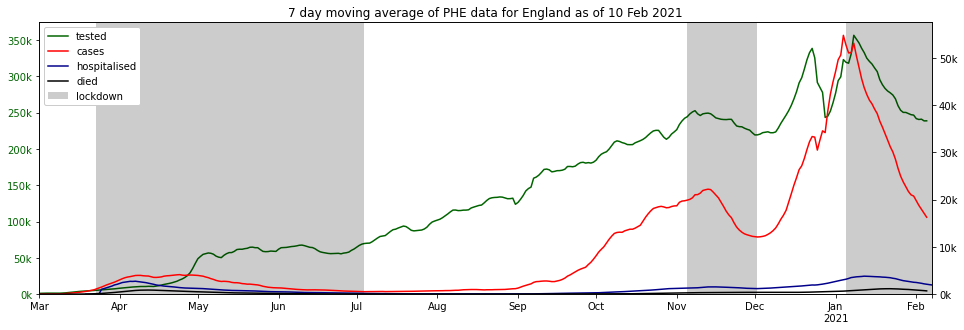

In [44]:
plot_summary(earliest_date='2020-03-01')

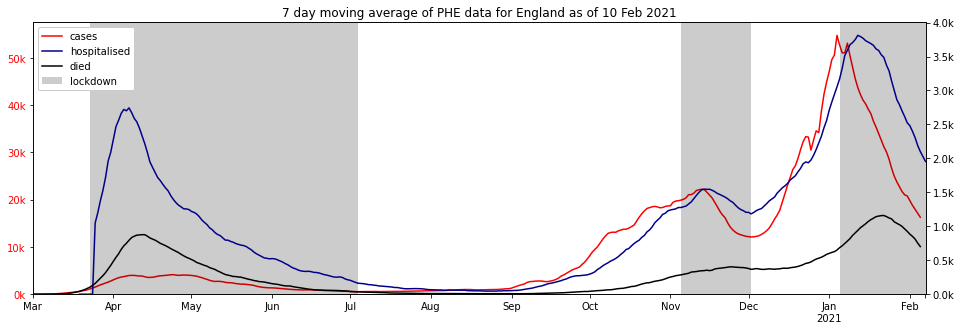

In [45]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

In [46]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-02-10.csv')

In [47]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-02-10.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,475228.0,11083652.0,10608424.0,56286961,0.844295,18.847036,80.308669
1,Northern Ireland,N92000002,27772.0,333658.0,305886.0,1893667,1.466573,16.153104,82.380323
2,Scotland,S92000003,12994.0,985569.0,972575.0,5463300,0.237842,17.801970,81.960189
3,Wales,W92000004,3687.0,655419.0,651732.0,3152879,0.116941,20.671012,79.212047


'partial: 13,058,298'

'full: 519,681'

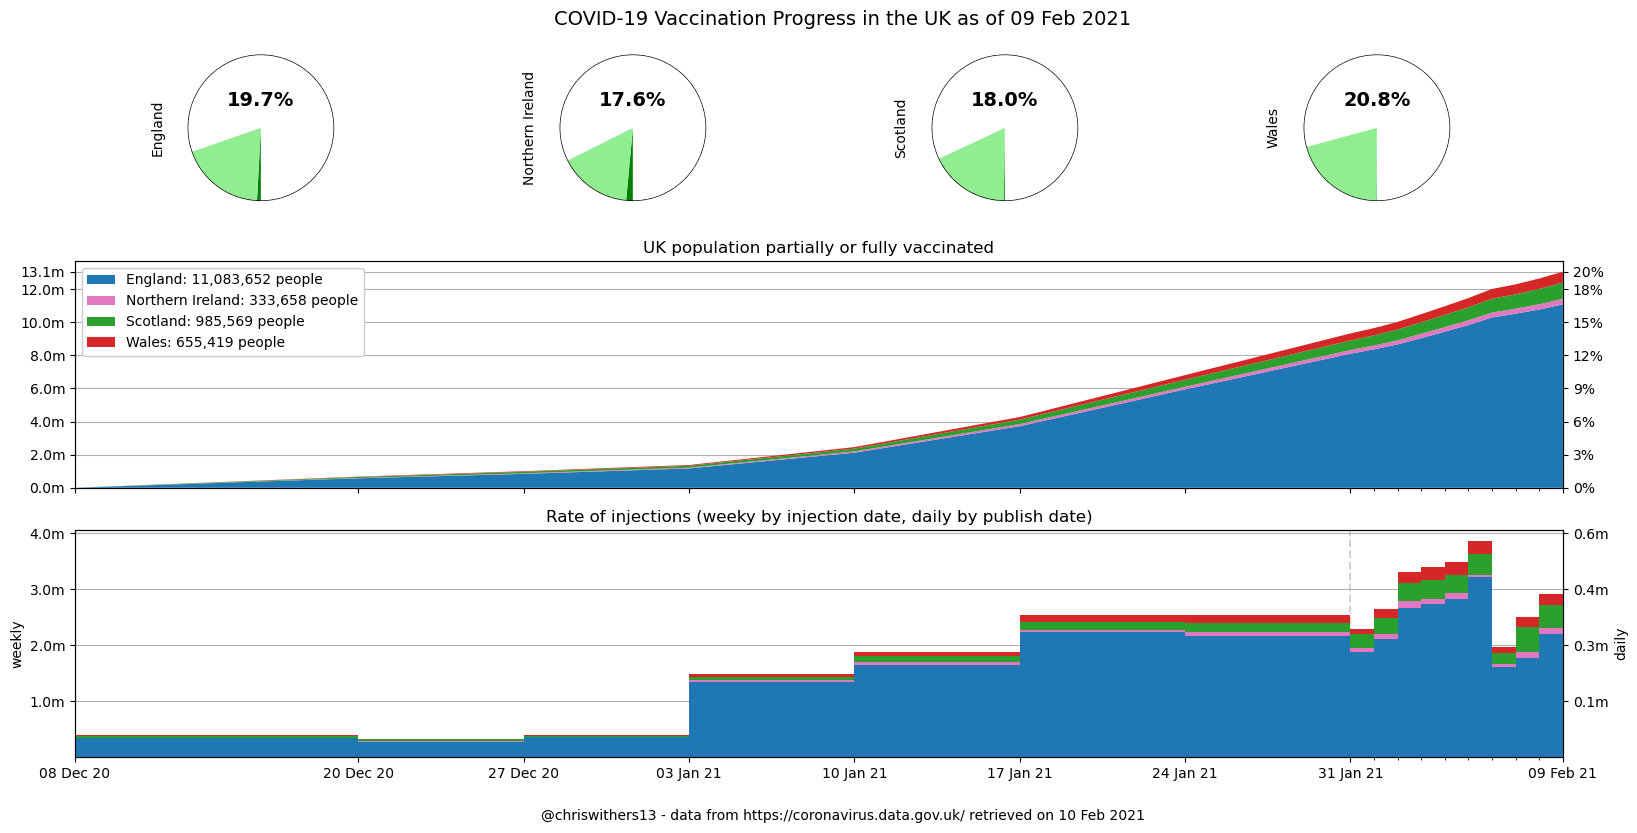

In [48]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [49]:
vaccination_changes()

,,First Dose (New),Second Dose (Total),Complete (New),First Dose (Total),cumPeopleVaccinatedSecondDoseByPublishDate,Complete (Total)
,,,,,,,
England,09 Feb 21,"+311,654","+2,173","+2,173","+11,083,652","+475,228","+475,228"
Northern Ireland,09 Feb 21,"+16,052",+183,+183,"+333,658","+27,772","+27,772"
Scotland,09 Feb 21,"+57,447",+609,+609,"+985,569","+12,866","+12,866"
Wales,09 Feb 21,"+26,659",+196,+196,"+655,419","+3,687","+3,687"


In [50]:
download(nation, nation, new_admissions, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-02-10.csv')

In [51]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-02-10.csv')

In [52]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-02-10.csv')